In [1]:
import numpy as np
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from long_range_ising_rg import *

In [11]:
import numpy as np
from numba import njit
from itertools import product

# ----------  spin configurations (global, read-only) ----------
all_spins = list(product([-1, 1], repeat=3))
plus_spins  = np.array([s for s in all_spins if sum(s) >= 1], dtype=np.float64)
minus_spins = np.array([s for s in all_spins if sum(s) <= -1], dtype=np.float64)

# ----------  intracell energy (J2 = nearest, J4 = next-nearest) ----------
@njit
def _intracell_energy(spins, J2, J4):
    n = spins.shape[0]
    E = np.zeros(n, dtype=np.float64)
    for i in range(n):
        s0, s1, s2 = spins[i, 0], spins[i, 1], spins[i, 2]
        E[i] = J2*s0*s1 + J2*s1*s2 + J4*s0*s2
    return E

# ----------  log-R for a pair of cells (H included) ----------
@njit
def _logR(spinsL, EL, spinsR, ER, dists, Jarr, H):
    nL, nR = spinsL.shape[0], spinsR.shape[0]
    nd = dists.shape[0]
    tot = np.zeros(nL*nR, dtype=np.float64)
    idx = 0
    for i in range(nL):
        magL = spinsL[i,0] + spinsL[i,1] + spinsL[i,2]
        for j in range(nR):
            magR = spinsR[j,0] + spinsR[j,1] + spinsR[j,2]
            Eint = 0.0
            for k in range(nd):
                iL, iR, d = dists[k]
                Eint += Jarr[d] * spinsL[i,iL] * spinsR[j,iR]
            tot[idx] = EL[i] + ER[j] + Eint + H*(magL + magR)
            idx += 1
    if tot.size == 0: return -np.inf
    mx = np.max(tot)
    s = np.sum(np.exp(tot - mx))
    return np.log(s) + mx if s > 0.0 else -np.inf

# ----------  H' for the nearest-neighbour cell pair (r'=1) ----------
@njit
def _Hprime(Jarr, H):
    J2, J4 = Jarr[2], Jarr[4]
    ELp = _intracell_energy(plus_spins,  J2, J4)
    ELm = _intracell_energy(minus_spins, J2, J4)

    # geometry of the two nearest-neighbour cells
    start = 4
    left  = np.array([1,3,5], dtype=np.int64)
    right = np.array([start, start+2, start+4], dtype=np.int64)
    dists = np.empty((9,3), dtype=np.int64)
    k = 0
    for iL in range(3):
        for iR in range(3):
            dists[k] = (iL, iR, abs(right[iR]-left[iL]))
            k += 1

    log_pp = _logR(plus_spins,  ELp, plus_spins,  ELp, dists, Jarr, H)
    log_mm = _logR(minus_spins, ELm, minus_spins, ELm, dists, Jarr, H)
    if np.isinf(log_pp) or np.isinf(log_mm): return np.nan
    return 0.25*(log_pp - log_mm)

# ----------  dH'/dH at H = 0 (finite difference) ----------
@njit
def dHdH(Jarr, eps=1e-8):
    H0   = _Hprime(Jarr, 0.0)
    Heps = _Hprime(Jarr, eps)
    if np.isnan(H0) or np.isnan(Heps): return np.nan
    return (Heps - H0)/eps

# ----------  renormalised coupling J'(r') (no Python callable) ----------
@njit
def _Jprime(start, Jarr):
    J2 = Jarr[2]
    J4 = Jarr[4]
    left  = np.array([1,3,5], dtype=np.int64)
    right = np.array([start, start+2, start+4], dtype=np.int64)
    dists = np.empty((9,3), dtype=np.int64)
    k = 0
    for iL in range(3):
        for iR in range(3):
            dists[k] = (iL, iR, abs(right[iR]-left[iL]))
            k += 1

    ELp = _intracell_energy(plus_spins,  J2, J4)
    ELm = _intracell_energy(minus_spins, J2, J4)

    log_pp = _logR(plus_spins,  ELp, plus_spins,  ELp, dists, Jarr, 0.0)
    log_pm = _logR(plus_spins,  ELp, minus_spins, ELm, dists, Jarr, 0.0)
    if np.isinf(log_pp) or np.isinf(log_pm): return np.inf
    return 0.5*(log_pp - log_pm)

# ----------  find critical Jc(a) (once) ----------
def find_Jc(a, max_k=1200, tol=1e-8, Jlow=0.1, Jhigh=12.0):
    if not (0 < a < 2): raise ValueError("a must be in (0,2)")

    md = 3*max_k + 10
    rs = np.arange(1, max_k+1, dtype=np.int64)

    def grows(J0):
        Jarr = np.zeros(md+1, dtype=np.float64)
        Jarr[1:] = J0 * np.power(np.arange(1, md+1, dtype=np.float64), -a)
        cur = Jarr.copy()
        for _ in range(8):                     # enough steps to see trend
            Jp = np.empty(max_k, dtype=np.float64)
            for ri in range(max_k):
                Jp[ri] = _Jprime(3*rs[ri]+1, cur)
            cur = np.zeros(md+1, dtype=np.float64)
            cur[1:max_k+1] = Jp
            if max_k > 1 and abs(Jp[1]) > 1e7: return True
            if max_k > 1 and abs(Jp[1]) < 1e-7: return False
        return abs(Jp[1]) > abs(Jarr[2])

    while Jhigh - Jlow > tol:
        Jmid = (Jlow + Jhigh)*0.5
        if grows(Jmid): Jhigh = Jmid
        else:           Jlow  = Jmid
    return (Jlow + Jhigh)*0.5

# Magnetisation by back-propagation
def magnetisation(J0, a, Jc, max_k=800, max_steps=30, eps=1e-8):
    """
    J0 – starting coupling (=1/T)
    a  – power-law exponent
    Jc – critical coupling for this a (from find_Jc)
    """
    b, d = 3.0, 1.0
    M_sink = 1.0 if J0 > Jc else 0.0
    if M_sink == 0.0: return 0.0

    md = 3*max_k + 10
    Jarr = np.zeros(md+1, dtype=np.float64)
    Jarr[1:] = J0 * np.power(np.arange(1, md+1, dtype=np.float64), -a)

    rs = np.arange(1, max_k+1, dtype=np.int64)
    cur = Jarr.copy()
    prodR = 1.0

    for step in range(max_steps):
        # ---- renormalise couplings ----
        Jp = np.empty(max_k, dtype=np.float64)
        for ri in range(max_k):
            Jp[ri] = _Jprime(3*rs[ri]+1, cur)

        # ---- dH'/dH at this level ----
        dh = dHdH(cur, eps)
        if np.isnan(dh) or dh <= 0.0: break
        prodR *= dh

        # ---- next lattice ----
        cur = np.zeros(md+1, dtype=np.float64)
        cur[1:max_k+1] = Jp

    scale = (b**(-d))**(step+1)
    M0 = scale * prodR * M_sink
    return M0
    #return np.clip(M0, 0.0, 1.0)

@njit
def _linearise_Jprime(Jarr_crit, max_k=800, eps=1e-8):
    """
    Build the Jacobian ∂J'_i / ∂J_j  at the critical point.
    Returns a (max_k × max_k) matrix.
    """
    md = 3*max_k + 10
    rs = np.arange(1, max_k+1, dtype=np.int64)
    n = max_k
    Jac = np.zeros((n, n), dtype=np.float64)

    # baseline J' (central difference needs two evaluations)
    Jp_base = np.empty(n, dtype=np.float64)
    for ri in range(n):
        Jp_base[ri] = _Jprime(3*rs[ri]+1, Jarr_crit)

    # perturb each input coupling J_k separately
    for k in range(n):
        Jarr_plus  = Jarr_crit.copy()
        Jarr_minus = Jarr_crit.copy()
        dJ = eps * max(1.0, abs(Jarr_crit[rs[k]]))
        if dJ == 0.0:
            dJ = eps
        Jarr_plus[rs[k]]  += dJ
        Jarr_minus[rs[k]] -= dJ

        Jp_plus  = np.empty(n, dtype=np.float64)
        Jp_minus = np.empty(n, dtype=np.float64)
        for ri in range(n):
            Jp_plus[ri]  = _Jprime(3*rs[ri]+1, Jarr_plus)
            Jp_minus[ri] = _Jprime(3*rs[ri]+1, Jarr_minus)

        Jac[:, k] = (Jp_plus - Jp_minus) / (2.0 * dJ)

    return Jac

def compute_exponents(a, max_k=800, eps_J=1e-8, eps_matrix=1e-8):
    """
    Full critical-exponent calculation for a given power-law exponent a.
    Returns a dictionary with y_T, y_H and all standard exponents.
    """
    # 1. find the critical coupling
    Jc = find_Jc(a, max_k=max_k, tol=1e-10)

    # 2. build the critical interaction array (large enough)
    md = 3*max_k + 10
    Jarr_crit = np.zeros(md+1, dtype=np.float64)
    Jarr_crit[1:] = Jc * np.power(np.arange(1, md+1, dtype=np.float64), -a)

    # 3. thermal eigenvalue y_T  (largest eigenvalue of the coupling Jacobian)
    Jac = _linearise_Jprime(Jarr_crit, max_k=max_k, eps=eps_matrix)
    eigenvals = np.linalg.eigvals(Jac)
    # the relevant thermal operator is the largest real eigenvalue > 1
    real_parts = np.real(eigenvals)
    y_T = np.max(real_parts[real_parts > 0])

    # 4. magnetic eigenvalue y_H  (logarithmic derivative of H' w.r.t. H at H=0)
    #    we already have dHdH, just evaluate at the critical point
    y_H = np.log(dHdH(Jarr_crit, eps=eps_J)) / np.log(3.0)   # b=3

    # 5. dimension
    d = 1.0

    # 6. standard exponents (exactly the formulae from the paper)
    beta = (d - y_H) / y_T
    delta = y_H / (d - y_H)
    eta = 2.0 + d - 2.0*y_H
    nu = 1.0 / y_T
    alpha = 2.0 - d / y_T
    gamma = (2.0*y_H - d) / y_T

    exponents = {
        'a'      : a,
        'Jc'     : Jc,
        'y_T'    : y_T,
        'y_H'    : y_H,
        'alpha'  : alpha,
        'beta'   : beta,
        'gamma'  : gamma,
        'delta'  : delta,
        'nu'     : nu,
        'eta'    : eta,
    }
    return exponents

# Critical exponents

In [ ]:
compute_exponents(a=1, max_k=10, eps_matrix=1e-7)

In [ ]:
a_vals = np.linspace(0.80, 1.99, 20)
results = [compute_exponents(a, max_k=10, eps_matrix=1e-7) for a in a_vals]

yT = [r['y_T'] for r in results]
yH = [r['y_H'] for r in results]
alpha = [r['alpha'] for r in results]
beta = [r['beta']  for r in results]
gamma = [r['gamma'] for r in results]
delta = [r['delta'] for r in results]
nu = [r['nu']    for r in results]
eta = [r['eta']   for r in results]

In [ ]:
plt.figure(figsize=(8, 4))
#plt.suptitle('Critical exponents for 1d long-range Ising model (0.80 ≤ a ≤ 1.99)', fontsize=14)

plt.subplot(1, 2, 1)
plt.plot(a_vals, yT, '-', color='#ff7f0e')
plt.xlabel('a'); plt.ylabel(r'$y_T$')

plt.subplot(1, 2, 2)
plt.plot(a_vals, yH, '-', color='#d62728')
plt.xlabel('a'); plt.ylabel(r'$y_H$')

plt.tight_layout()
plt.savefig(f'../figures/critical_exponents_yT_yH.png')
plt.show()

In [ ]:
plt.figure(figsize=(13, 8))
#plt.suptitle('Critical exponents for 1d long-range Ising model (0.80 ≤ a ≤ 1.99)', fontsize=14)

plt.subplot(2, 3, 1)
plt.plot(a_vals, beta, '-', color='#ff7f0e', ms=4)
plt.xlabel('a'); plt.ylabel(r'$\beta$')

plt.subplot(2, 3, 2)
plt.plot(a_vals, delta, '-', color='#d62728', ms=4)
plt.xlabel('a'); plt.ylabel(r'$\delta$')

plt.subplot(2, 3, 3)
plt.plot(a_vals, alpha, '-', color='#1f77b4', ms=4)
plt.xlabel('a'); plt.ylabel(r'$\alpha$')

plt.subplot(2, 3, 4)
plt.plot(a_vals, gamma, '-', color='#2ca02c', ms=4)
plt.xlabel('a'); plt.ylabel(r'$\gamma$')

plt.subplot(2, 3, 5)
plt.plot(a_vals, nu, '-', color='#9467bd', ms=4)
plt.xlabel('a'); plt.ylabel(r'$\nu$')

plt.subplot(2, 3, 6)
plt.plot(a_vals, eta, '-', color='#8c564b', ms=4)
plt.xlabel('a'); plt.ylabel(r'$\eta$')

plt.tight_layout()
plt.savefig(f'../figures/critical_exponents.png')
plt.show()

# Critical temperature

In [ ]:
# Cell 1 – critical coupling
a = 1.3
Jc = find_Jc(a, max_k=1200, tol=1e-9)
print(f"a = {a:.3f}  →  Jc = {Jc:.10f}  (Tc = {1/Jc:.6f})")

# dH'/dH at Tc

In [ ]:
# Cell 2 – dH'/dH at the critical point
max_d = 3*1200 + 10
Jarr_crit = np.zeros(max_d+1, dtype=np.float64)
Jarr_crit[1:] = Jc * np.power(np.arange(1, max_d+1, dtype=np.float64), -a)

dh = dHdH(Jarr_crit, eps=1e-9)
yH = np.log(dh)/np.log(3.0)
print(f"dH'/dH = {dh:.6f}   →   y_H = {yH:.4f}")

## a vs dH'/dH

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---
a_vals = np.linspace(0.8, 1.95, 30)   # avoid a=2.0 (first-order)
max_k = 1200
tol = 1e-9
eps = 1e-9

dh_vals = []
Jc_vals = []

print("Computing dH'/dH at criticality for a in [0.8, 1.95]...")
for a in a_vals:
    try:
        Jc = find_Jc(a, max_k=max_k, tol=tol)
        max_d = 3*max_k + 10
        Jarr = np.zeros(max_d+1, dtype=np.float64)
        Jarr[1:] = Jc * np.power(np.arange(1, max_d+1, dtype=np.float64), -a)
        
        dh = dHdH(Jarr, eps=eps)
        yH = np.log(dh)/np.log(3.0) if dh > 0 else np.nan
        
        dh_vals.append(dh)
        Jc_vals.append(Jc)
        print(f"a = {a:.3f} → Jc = {Jc:.6f}, dH'/dH = {dh:.6f}, y_H = {yH:.4f}")
    except:
        dh_vals.append(np.nan)
        Jc_vals.append(np.nan)

# --- PLOT ---
plt.figure(figsize=(7, 5))
valid = ~np.isnan(dh_vals)
plt.semilogy(np.array(a_vals)[valid], np.array(dh_vals)[valid], 
             'o-', color='tab:blue', markersize=5, linewidth=1.8, label="$\\partial H'/\\partial H$")

plt.xlabel('Interaction Range Exponent $a$')
plt.ylabel("$\\partial H'/\\partial H \\,|_{H=0}$")
plt.title('Field Renormalization at Criticality')
plt.grid(True, alpha=0.3, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# M(T)

In [ ]:
# Cell 3 – magnetisation at a chosen temperature
J0 = 1.8                       # = 1/T
M  = magnetisation(J0, a, Jc, max_k=800, max_steps=35)
print(f"J0 = {J0:.3f} (T = {1/J0:.3f})  →  M0 = {M:.6f}")

# T vs. M(T)

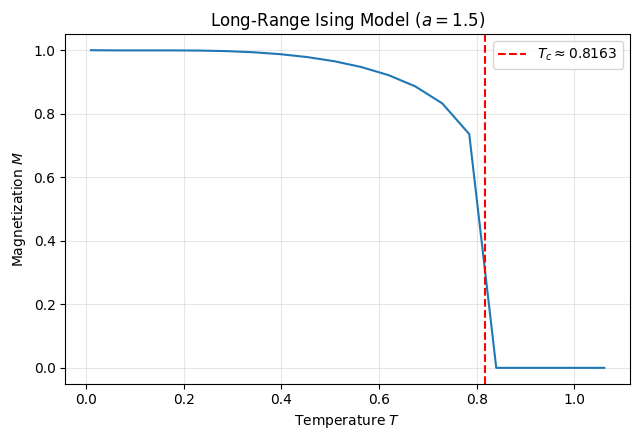

In [58]:
import numpy as np
import matplotlib.pyplot as plt

a = 1.5
Jc = find_Jc(a, max_k=3**7, tol=1e-9)
Tc = 1.0 / Jc

# Temperature range: from 0.3*Tc to 3*Tc (log scale)
Tvals = np.linspace(0.01, 1.3*Tc, 20)

# Compute magnetisation
step = 12
Mvals = [magnetisation(1.0/T, a, Jc, max_k=3**step, max_steps=step) for T in Tvals]

# --- PLOT ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(Tvals, Mvals, '-', color='tab:blue', markersize=4, linewidth=1.5)
plt.axvline(Tc, color='red', linestyle='--', linewidth=1.5, label=f'$T_c \\approx {Tc:.4f}$')
plt.xlabel('Temperature $T$')
plt.ylabel('Magnetization $M$')
plt.title(f'Long-Range Ising Model ($a = {a}$)')
plt.grid(True, alpha=0.3)
plt.legend()
#plt.xlim(0, )
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_a{a}.png')
plt.show()

## T vs M(T) for multiple a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Choose the exponents a and a common temperature grid
a_values = np.linspace(1.2, 1.999, 8)
step = 12
max_k = 3**step
tol = 1e-5
# Temperature range (linear) that covers all Tc:
Tc_max = 1.0 / find_Jc(a_values[0], max_k=3**8, tol=tol)   # largest Tc (smallest a)
T_min, T_max = 0.01, 1.2 * Tc_max
Tvals = np.linspace(T_min, T_max, 200)

# Compute Jc for every a (once) and then M(T) for each a
M_matrix = np.zeros((len(Tvals), len(a_values)))   # rows = T, columns = a

Tc_values = []
for i, a in enumerate(a_values):
    print(f"a={a}")
    Jc = find_Jc(a, max_k=max_k, tol=tol)  # critical coupling
    # magnetisation for every temperature in the grid
    M_matrix[:, i] = [
        magnetisation(1.0/T, a, Jc, max_k=max_k, max_steps=step) if T > 0 else 0.0
        for T in Tvals
    ]
    Tc_values.append(1/Jc)

# Plot with a colormap
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for i, a_i in enumerate(a_values):
    ax.plot(Tvals, M_matrix[:, i], marker='', linewidth=2, color=cmap(norm(a_i)))

# colour-bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent a')

ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Magnetization M')
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 2)
ax.grid(False)
plt.tight_layout()
#plt.savefig('../figures/magnetization_all_a_cut.png')
plt.show()

--- a = 0.80000 ---
  Tc = 9.999716,  points = 100\n
--- a = 0.97129 ---
  Tc = 4.349926,  points = 100\n
--- a = 1.14257 ---
  Tc = 2.156509,  points = 100\n
--- a = 1.31386 ---
  Tc = 1.310712,  points = 100\n
--- a = 1.48514 ---
  Tc = 0.863144,  points = 100\n
--- a = 1.65643 ---
  Tc = 0.588525,  points = 100\n
--- a = 1.82771 ---
  Tc = 0.404292,  points = 100\n
--- a = 1.99900 ---
  Tc = 0.271733,  points = 100\n


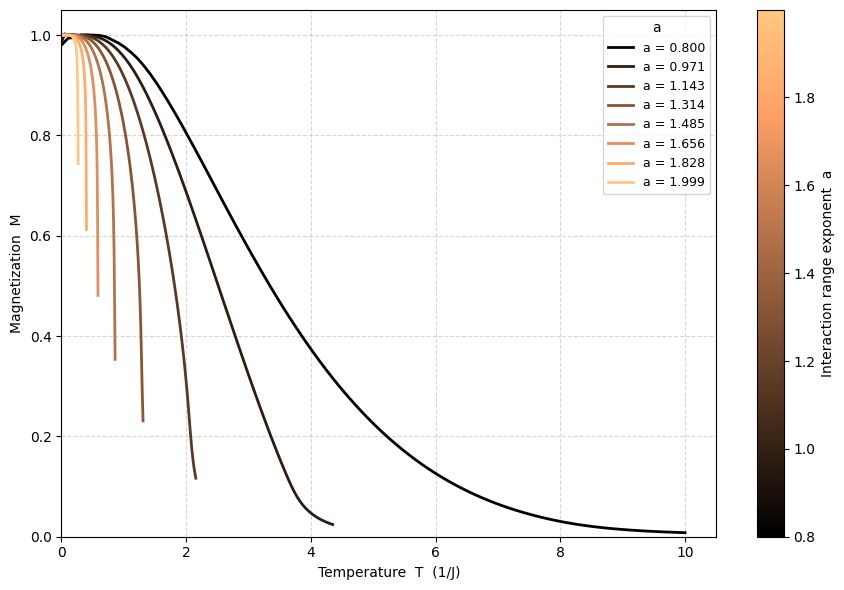

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --------------------------------------------------------------
# 1. Parameters
# --------------------------------------------------------------
step   = 10
max_k  = 3**step          # 3^8 = 6561
eps    = 1e-5
N      = 100               # points per curve (up to Tc)
a_values = np.linspace(0.8, 1.999, 8)

# --------------------------------------------------------------
# 2. Containers
# --------------------------------------------------------------
Tc_values  = []                            # 1/Jc for each a
data_by_a  = []                            # <-- NEW: list of (T,M) tuples per a

# --------------------------------------------------------------
# 3. Main loop – compute Jc, T-grid, M(T) and pack tuples
# --------------------------------------------------------------
for i, a in enumerate(a_values):
    print(f"--- a = {a:.5f} ---")
    Jc = find_Jc(a, max_k=max_k, tol=eps)          # critical coupling
    Tc = 1.0 / Jc
    Tc_values.append(Tc)

    # temperature grid **only up to Tc** (exclude Tc itself to avoid division-by-zero)
    Tvals = np.linspace(0.01, Tc - eps, N)

    # magnetisation for every T
    Mvals = np.array([
        magnetisation(1.0/T, a, Jc, max_k=max_k, max_steps=step) if T > 0 else 0.0
        for T in Tvals
    ])

    # ---- NEW: pack (T, M) tuples for THIS a ----
    tuples_for_a = [(float(T), float(M)) for T, M in zip(Tvals, Mvals)]
    data_by_a.append(tuples_for_a)

    # quick sanity print
    print(f"  Tc = {Tc:.6f},  points = {len(tuples_for_a)}\\n")

# --------------------------------------------------------------
# 4. Plot everything
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for i, (a, tuples_a) in enumerate(zip(a_values, data_by_a)):
    T_arr = np.array([t[0] for t in tuples_a])
    M_arr = np.array([t[1] for t in tuples_a])
    ax.plot(T_arr, M_arr,
            label=f'a = {a:.3f}',
            color=cmap(norm(a)),
            linewidth=2)

# colour-bar (shows the a-value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction range exponent  a')

ax.set_xlabel('Temperature  T  (1/J)')
ax.set_ylabel('Magnetization  M')
ax.set_xlim(0, None)
ax.set_ylim(0, 1.05)
ax.grid(True, ls='--', alpha=0.5)
ax.legend(title='a', loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
import csv

csv_filename = '../data/TM_data_by_a.csv'

with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['# a_index', 'a_value', 'Tc', 'T', 'M'])
    for i, (a, Tc, tuples_a) in enumerate(zip(a_values, Tc_values, data_by_a)):
        for T, M in tuples_a:
            writer.writerow([i, a, Tc, T, M])

print(f"Saved to {csv_filename}")

Saved to ../data/TM_data_by_a.csv


Loaded 8 curves from ../data/TM_data_by_a.csv


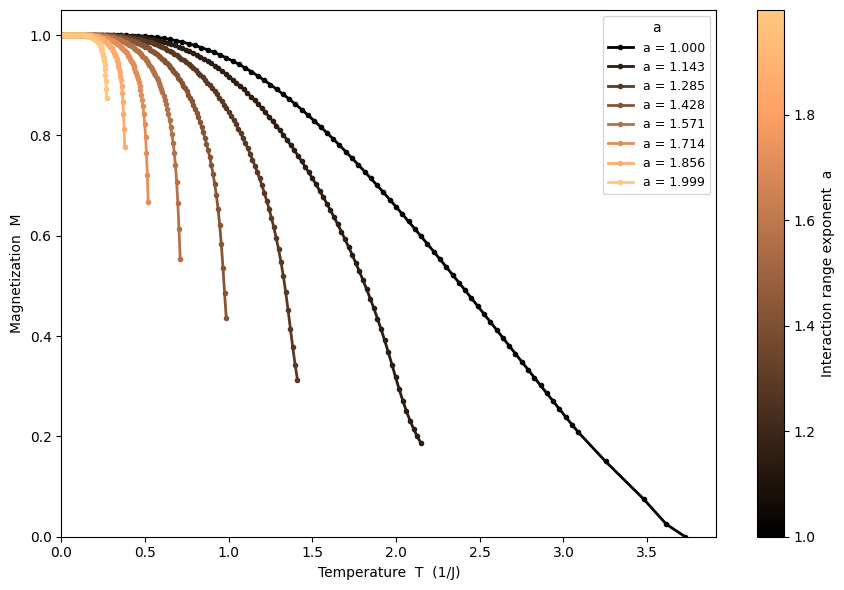

In [31]:
import csv
import numpy as np

csv_filename = '../data/TM_data_by_a.csv'

# temporary containers
a_list      = []
Tc_list     = []
data_by_a   = []      # will be list of lists of tuples

with open(csv_filename, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)      # skip header
    for row in reader:
        if row[0].startswith('#'):   # safety for comment lines
            continue
        i   = int(row[0])
        a   = float(row[1])
        Tc  = float(row[2])
        T   = float(row[3])
        M   = float(row[4])

        # expand lists up to index i if needed
        while len(a_list) <= i:
            a_list.append(None)
            Tc_list.append(None)
            data_by_a.append([])
        a_list[i]   = a
        Tc_list[i]  = Tc
        data_by_a[i].append((T, M))

# convert back to numpy arrays for convenience
a_values   = np.array(a_list)
Tc_values  = np.array(Tc_list)

print(f"Loaded {len(data_by_a)} curves from {csv_filename}")

fig, ax = plt.subplots(figsize=(9, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for i, (a, tuples_a) in enumerate(zip(a_values, data_by_a)):
    T_arr = np.array([t[0] for t in tuples_a])
    M_arr = np.array([t[1] for t in tuples_a])
    ax.plot(T_arr, M_arr, marker='.',
            label=f'a = {a:.3f}',
            color=cmap(norm(a)),
            linewidth=2)

# colour-bar (shows the a-value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction range exponent  a')

ax.set_xlabel('Temperature  T  (1/J)')
ax.set_ylabel('Magnetization  M')
ax.set_xlim(0, None)
ax.set_ylim(0, 1.05)
#ax.grid(True, ls='--', alpha=0.5)
ax.legend(title='a', loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

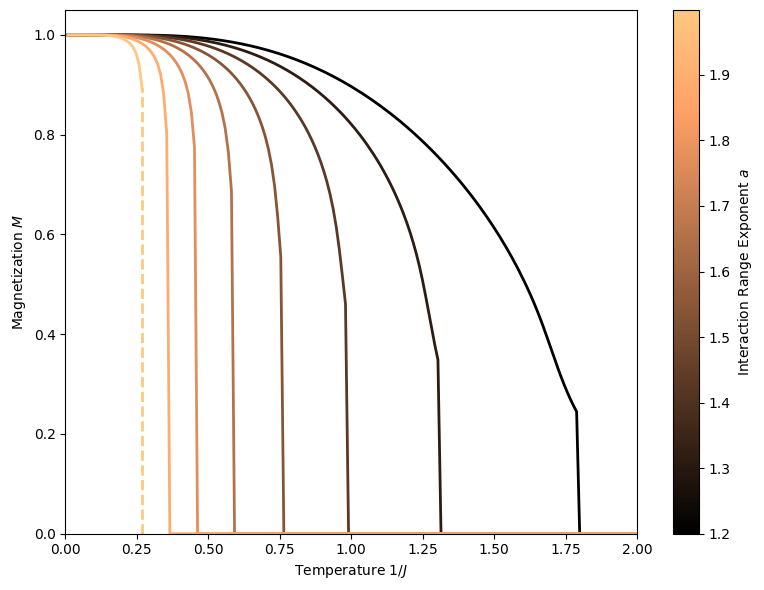

In [52]:
# Plot with a colormap
fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())


ax.plot(Tvals, M_matrix[:, 0], marker='', linewidth=2, color=cmap(norm(a_values[0])))
ax.plot(Tvals, M_matrix[:, 1], marker='', linewidth=2, color=cmap(norm(a_values[1])))

ax.plot(Tvals, M_matrix[:, 2], marker='', linewidth=2, color=cmap(norm(a_values[2])))
ax.plot(Tvals, M_matrix[:, 3], marker='', linewidth=2, color=cmap(norm(a_values[3])))
ax.plot(Tvals, M_matrix[:, 4], marker='', linewidth=2, color=cmap(norm(a_values[4])))
ax.plot(Tvals, M_matrix[:, 5], marker='', linewidth=2, color=cmap(norm(a_values[5])))
ax.plot(Tvals, M_matrix[:, 6], marker='', linewidth=2, color=cmap(norm(a_values[6])))

mask = Tvals < Tc_values[7]
ax.plot(Tvals[mask], M_matrix[:, 7][mask], marker='', linewidth=2, color=cmap(norm(a_values[7])))

mask = Tvals < Tc_values[-1]
Tc_max_a = Tvals[mask][-1]
M_at_Tc = M_matrix[:, 7][Tvals < Tc_values[7]][-1]  # last M before Tc

ax.plot([Tc_max_a, Tc_max_a], [0, M_at_Tc], color=cmap(norm(a_values[7])), linestyle='--', linewidth=2)

# colour-bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent $a$')

ax.set_xlabel('Temperature $1/J$')
ax.set_ylabel('Magnetization $M$')
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 2)
ax.grid(False)

plt.tight_layout()
plt.savefig('../figures/magnetization_a.png', dpi=300)
plt.show()

# yT via Newton-Raphson